<a href="https://colab.research.google.com/github/CelaPablo/SOA-EA2/blob/master/HPC/Cela_Pablo_ejercicio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Introducción

intro

---
# Armado del ambiente

???

In [ ]:
# Posible armado de ambiente

---
# Desarrollo

???

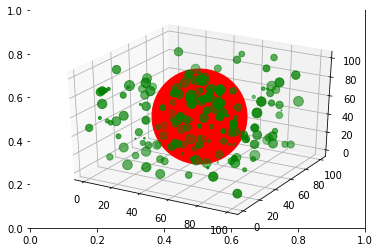

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

cuerpos = 180#@param {type: "number"}
colores = ['green'] * cuerpos

x_cpu  = np.random.uniform(0, 100, size=cuerpos)
y_cpu  = np.random.uniform(0, 100, size=cuerpos)
z_cpu  = np.random.uniform(0, 100, size=cuerpos)
m_cpu  = np.random.uniform(0, 100, size=cuerpos)

cdmx = 0
cdmy = 0
cdmz = 0
masas = 0

m = 0

for i in range( 0, cuerpos ):
  m = m_cpu[i]
  cdmx += x_cpu[i] * m
  cdmy += y_cpu[i] * m
  cdmz += z_cpu[i] * m
  masas += m

cdmx /= masas
cdmy /= masas
cdmz /= masas

fig, ax = plt.subplots()
ax1 = fig.add_subplot(111, projection="3d")
ax1.scatter(x_cpu, y_cpu, z_cpu, c=colores, s=m_cpu)
ax1.scatter(cdmx, cdmy, cdmz, c='red', s=masas)

In [ ]:

code = """
// Calculo de centro de masas de cuerpos libres con OpenMP - usando C.

#include <iostream>
#include <vector>
#include <cstdlib>
#include <sys/time.h>
#include <omp.h>

// ----------------------------------------------------------------------------
// Macros que miden el tiempo.

static double dHashTiempoHistory[3];
static struct timeval tv;

#define TIEMPO_INI( h )      \
   gettimeofday(&tv,NULL);   \
   dHashTiempoHistory[ h ] = tv.tv_sec + tv.tv_usec/1000000.0;
   
   
#define TIEMPO_FIN( h )      \
   gettimeofday(&tv,NULL);   \
   dHashTiempoHistory[ h ] = ((tv.tv_sec + tv.tv_usec/1000000.0) - dHashTiempoHistory[ h ]) * 1000; // Devuelvo en milisegundos
#define TIEMPO_GET( h ) dHashTiempoHistory[ h ]

#define HTH_TOTAL         1
#define HTH_AXPY_SEC      2
#define HTH_AXPY_OMP      3

// ----------------------------------------------------------------------------

int main(int argc, char* argv[]) 
{ 
  int i,c;
  TIEMPO_INI( HTH_TOTAL )

  // Lectura de parametros.
  if( argc != 4 )
  {
      std::cerr<< " Error en los parametros de indicar: (Tamanio vector), (ciclos ejecucion)."<<argc<<std::endl;
      exit( -1 );
  }

  float alfa     = atof( argv[1] );
  int cantidad_N = atoi( argv[2] );
  int ciclos     = atoi( argv[3] );

  // --------------------------------------------
  // Defino la memoria de los vectores.

  std::vector<double> X( cantidad_N );
  std::vector<double> Y( cantidad_N );

  for (int i=0;i<X.size();i++)
  {
    X[i] = (rand()/(double)RAND_MAX)*0.73;
    Y[i] = (rand()/(double)RAND_MAX)*0.73;
  }

  // --------------------------------------------
  // Realizo la función Axpy en forma secuencial.

  TIEMPO_INI( HTH_AXPY_SEC )

  for(c=0;c<ciclos;c++)
  {
    for(i=0;i<Y.size();i++)
    {
      Y[i] = alfa * X[i] + Y[i];
    }
  }

  TIEMPO_FIN( HTH_AXPY_SEC )

  // --------------------------------------------
  // Realizo la función Axpy con OpenMP.

  TIEMPO_INI( HTH_AXPY_OMP )

  for(c=0;c<ciclos;c++)
  {
    #pragma omp parallel for
    for(i=0;i<Y.size();i++)
    {
      Y[i] = alfa * X[i] + Y[i];
    }
  }

  TIEMPO_FIN( HTH_AXPY_OMP )

  // --------------------------------------------
  // Muestro los resultados.
/*
  std::cout<<" X : ["; 
  for(i=0;i<X.size();i++)
  {
    std::cout<<X[i]<< ", ";
  }
  std::cout<<"]"<<std::endl; 

  std::cout<<" Y : ["; 
  for(i=0;i<Y.size();i++)
  {
    std::cout<<Y[i]<< ", ";
  }
  std::cout<<"]"<<std::endl; 
*/

  TIEMPO_FIN( HTH_TOTAL )

 std::cout<<"Valores Reales  :" <<std::endl;
 std::cout<<"Tiempo TOTAL     : "<<TIEMPO_GET(HTH_TOTAL   )<<" [ms]"<<std::endl;
 std::cout<<"Tiempo axpy Sec  : "<<TIEMPO_GET(HTH_AXPY_SEC)<<" [ms]"<<std::endl;
 std::cout<<"Tiempo axpy Omp  : "<<TIEMPO_GET(HTH_AXPY_OMP)<<" [ms]"<<std::endl;
 std::cout<<std::endl;
 std::cout<<"SpeedUp          : (tiempo Secuencial/tiempo paralelo) : "<<TIEMPO_GET(HTH_AXPY_SEC)<<" / "<<TIEMPO_GET(HTH_AXPY_OMP)<<" = "<<TIEMPO_GET(HTH_AXPY_SEC)/TIEMPO_GET(HTH_AXPY_OMP)<<std::endl;
 std::cout<<"Eficiencia       : SpeedUp/nro procesadores            : "<<TIEMPO_GET(HTH_AXPY_SEC)/TIEMPO_GET(HTH_AXPY_OMP)<<" / "<<omp_get_num_procs()<<" = "<<TIEMPO_GET(HTH_AXPY_SEC)/(omp_get_num_procs()*TIEMPO_GET(HTH_AXPY_OMP))<<std::endl;
 std::cout<<"Coste Sec        : nro procesadores*Tiempo             : "<<1<<" * "<<TIEMPO_GET(HTH_AXPY_SEC)<<" = "<<TIEMPO_GET(HTH_AXPY_SEC)<<std::endl;
 std::cout<<"Coste Omp        : nro procesadores*Tiempo             : "<<omp_get_num_procs()<<" * "<<TIEMPO_GET(HTH_AXPY_OMP)<<" = "<<omp_get_num_procs()*TIEMPO_GET(HTH_AXPY_OMP)<<std::endl;
 std::cout<<"Funcion Overhead : Coste Omp - tiempo Secuencial       : "<<omp_get_num_procs()*TIEMPO_GET(HTH_AXPY_OMP)<<" - "<<TIEMPO_GET(HTH_AXPY_SEC)<<" = "<<(omp_get_num_procs()*TIEMPO_GET(HTH_AXPY_OMP))-TIEMPO_GET(HTH_AXPY_SEC)<<std::endl;


 std::cout<<std::endl;
 std::cout<<"Valores Ideal: "<<std::endl;
 TIEMPO_GET(HTH_AXPY_OMP) = TIEMPO_GET(HTH_AXPY_SEC) / 2;
 std::cout<<"Tiempo axpy Sec  : "<<TIEMPO_GET(HTH_AXPY_SEC)<<" [ms]"<<std::endl;
 std::cout<<"Tiempo axpy Omp  : "<<TIEMPO_GET(HTH_AXPY_OMP)<<" [ms]"<<std::endl;

 std::cout<<"SpeedUp          : (tiempo Secuencial/tiempo paralelo) : "<<TIEMPO_GET(HTH_AXPY_SEC)<<" / "<<TIEMPO_GET(HTH_AXPY_OMP)<<" = "<<TIEMPO_GET(HTH_AXPY_SEC)/TIEMPO_GET(HTH_AXPY_OMP)<<std::endl;
 std::cout<<"Eficiencia       : SpeedUp/nro procesadores            : "<<TIEMPO_GET(HTH_AXPY_SEC)/TIEMPO_GET(HTH_AXPY_OMP)<<" / "<<omp_get_num_procs()<<" = "<<TIEMPO_GET(HTH_AXPY_SEC)/(omp_get_num_procs()*TIEMPO_GET(HTH_AXPY_OMP))<<std::endl;
 std::cout<<"Coste Sec        : nro procesadores*Tiempo             : "<<1<<" * "<<TIEMPO_GET(HTH_AXPY_SEC)<<" = "<<TIEMPO_GET(HTH_AXPY_SEC)<<std::endl;
 std::cout<<"Coste Omp        : nro procesadores*Tiempo             : "<<omp_get_num_procs()<<" * "<<TIEMPO_GET(HTH_AXPY_OMP)<<" = "<<omp_get_num_procs()*TIEMPO_GET(HTH_AXPY_OMP)<<std::endl;
 std::cout<<"Funcion Overhead : Coste Omp - tiempo Secuencial       : "<<omp_get_num_procs()*TIEMPO_GET(HTH_AXPY_OMP)<<" - "<<TIEMPO_GET(HTH_AXPY_SEC)<<" = "<<(omp_get_num_procs()*TIEMPO_GET(HTH_AXPY_OMP))-TIEMPO_GET(HTH_AXPY_SEC)<<std::endl;


}
// ----------------------------------------------------------------------------

"""
text_file = open("code_axpy.cpp", "w")
text_file.write(code)
text_file.close()


In [ ]:
text_file = open("code.c", "w")
text_file.write(code)
text_file.close()

In [ ]:
%env OMP_NUM_THREADS=10

env: OMP_NUM_THREADS=10


In [ ]:
!gcc -o ejercicioTres -fopenmp code.c

In [ ]:
!./ejercicioTres

Hello World... from thread = 0
Hello World... from thread = 1
Hello World... from thread = 2
Hello World... from thread = 3
Hello World... from thread = 4
Hello World... from thread = 5
Hello World... from thread = 6
Hello World... from thread = 7
Hello World... from thread = 8
Hello World... from thread = 9


---
# Tabla de pasos de ejecución del programa


 Procesador | Funciòn | Detalle
------------|---------|----------




No se si es necesario --


---
# Conclusión

???

---
# Bibliografía

???